In [325]:
import requests
import re
import pandas as pd
import numpy as np
import random
import seaborn as sns

from matplotlib import pyplot as plt
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver

from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

plt.rcParams['figure.figsize'] = (10,8) # размер графиков
sns.set()
RANDOM_STATE = 17 # зафиксировали для воспроизводимости результатов

# 1.Парсинг

In [43]:
page_url_pattern = "https://www.cian.ru/cat.php?deal_type=sale&district%5B0%5D=13&district%5B1%5D=14&district%5B2%5D=15&\
            district%5B3%5D=16&district%5B4%5D=17&district%5B5%5D=18&district%5B6%5D=19&district%5B7%5D=20&district\
            %5B8%5D=21&district%5B9%5D=22&engine_version=2&offer_type=flat&p={}&room1=1"
NUM_PAGES = 40

## 1.1 Сбор ссылок на страницы квартир

In [45]:
def get_page_links(page_soup):
    page_links = set()
    try:
        for html_link in page_soup.html.body.findAll('a', href=re.compile("https://www.cian.ru/sale/flat/\d+")):
            page_links.add(html_link['href'])
    except:
        print("Ошибка при получении списка ссылок на квартиры")
    finally:
        print(f"Получено {len(page_links)} ссылок")
    return page_links

In [46]:
links = set()
for page in range(1,NUM_PAGES + 1):
    print(f"Page {page} started")
    page_content = requests.get(page_url_pattern.format(page)).content
    page_soup = BeautifulSoup(page_content,'lxml')
    links = links.union(get_page_links(page_soup))

Page 1 started
Получено 28 ссылок
Page 2 started
Получено 28 ссылок
Page 3 started
Получено 28 ссылок
Page 4 started
Получено 28 ссылок
Page 5 started
Получено 28 ссылок
Page 6 started
Получено 28 ссылок
Page 7 started
Получено 28 ссылок
Page 8 started
Получено 28 ссылок
Page 9 started
Получено 28 ссылок
Page 10 started
Получено 28 ссылок
Page 11 started
Получено 28 ссылок
Page 12 started
Получено 28 ссылок
Page 13 started
Получено 28 ссылок
Page 14 started
Получено 28 ссылок
Page 15 started
Получено 28 ссылок
Page 16 started
Получено 28 ссылок
Page 17 started
Получено 28 ссылок
Page 18 started
Получено 28 ссылок
Page 19 started
Получено 28 ссылок
Page 20 started
Получено 28 ссылок
Page 21 started
Получено 28 ссылок
Page 22 started
Получено 28 ссылок
Page 23 started
Получено 28 ссылок
Page 24 started
Получено 28 ссылок
Page 25 started
Получено 28 ссылок
Page 26 started
Получено 28 ссылок
Page 27 started
Получено 28 ссылок
Page 28 started
Получено 28 ссылок
Page 29 started
Получено 28 с

In [51]:
with open('links.txt', 'w') as file:
    for link in links:
        file.write(link + "\n")

## 1.2 Сбор информации о квартирах
По каждой квартире будем собирать следующую информацию:
- **price** - цена квартиры (млн руб)
- **total_square** - общая площадь квартиры ($м^2$)
- **living_square** - жилая площадь ($м^2$)
- **kitchen_square** - площадь кухни ($м^2$)
- **underground_time** - время необходимое, чтобы добраться до метро (мин)
- **underground_way** - 0 - на транспорте, 1 - пешком
- **ceiling_height** - высота потолков в квартире
- **floor_number** - номера этажа квартиры
- **floors_count** - количество этажей в доме
- **is_balcony** - 1 - есть балкон или лоджия, 0 - нет
- **is_new** - 1 - новостройка, 0 - вторичное
- **region** - округ москвы (ЦАО, ЗАО)

In [6]:
# функция берет на вход soup-объект загруженного описания квартиры и возвращает цену на квартиру
def price_grabber(flat_soup):
    try:
        price = flat_soup.find('span', attrs={'class':re.compile(".*price_value.*")}).text
        return re.sub("\D","",price)
    except:
        return np.nan

In [7]:
#функция обрабатывает info_block и извлекает из него площади квартиры и этажность
def square_and_floor_grabber(info_block):
    total_square, living_square, kitchen_square, floor_number, floors_count = (np.nan,)*5
    
    info_block = flat_soup.find('div', attrs={'class':re.compile('.*info-block.*')})
    if not info_block: # нет блока с общей площадью и этажами
        return [np.nan]*5
    
    for child in info_block.findChildren('div', recursive=False):
        try:
            info_title = child.find('div', attrs={'class':re.compile(".*info-title.*")}).text.strip()
            info = child.find('div', attrs={'class':re.compile(".*info-text.*")}).text.strip()
            if info_title == 'Общая':
                total_square = parse_square(info)
            elif info_title == 'Жилая':
                living_square = parse_square(info)
            elif info_title == 'Кухня':
                kitchen_square = parse_square(info)
            elif info_title == 'Этаж':
                floors_info = info.split(" из ")
                floor_number = floors_info[0]
                floors_count = floors_info[1]
            else:
                pass
        except Exception as e:
            print(str(e))
            return [np.nan]*5
    return [total_square, living_square, kitchen_square, floor_number, floors_count]

In [8]:
# Делает преобрзование 30,8 м2 -> 30.8
def parse_square(square):
    square = square.replace(",",".")
    return re.findall(r"\d+\.?\d*", square)[0]

In [9]:
# возвращает информацию о временной удаленности от метро и способе до него добираться
def underground_grabber(flat_soup):
    try:
        underground_info = flat_soup.find('span', attrs={'class':re.compile('.*--underground_time--.*')}).get_text()
        underground_time = re.findall(r"\d+", underground_info)[0]
        if 'пешком' in underground_info:
            underground_way = '1'
        else:
            underground_way = '0'
    except Exception as e:
        print(str(e))
        return [np.nan]*2
    return [underground_time, underground_way]

In [10]:
#возвращает информацию о типе жилья, высоте потолков и наличии балкона
def general_info_grabber(flat_soup):
    is_new, ceiling_height, is_balcony = (np.nan,)*3
    
    general_info_block = flat_soup.find('ul', attrs={'class':re.compile('.*--list--.*')})
    if not general_info_block: # Не нашли блока с общей информацией
        return [np.nan]*3
    
    for info_item in general_info_block.findChildren('li', recursive=False):
        try:
            info_type = info_item.find('span', attrs={'class':re.compile(".*name.*")}).text.strip().lower() # Тип жилья
            info_value = info_item.find('span', attrs={'class':re.compile(".value.*")}).text.strip().lower()# Новостройка
            if info_type == 'тип жилья':
                if 'новостройка' in info_value:
                    is_new = '1'
                else:
                    is_new = '0'
            elif info_type == 'высота потолков':
                info_value = info_value.replace(",",".")
                ceiling_height = re.findall(r"\d+\.?\d*", info_value)[0]
            elif 'балкон' in info_type or 'лоджия' in info_type:
                if 'не' not in info_value:
                    is_balcony = '1'
                else:
                    is_balcony = '0'
            else:
                 pass
        except Exception as e:
            print(e)
            return [np.nan]*3
        
        
    return [is_new, ceiling_height, is_balcony]

In [11]:
# извлекает из адреса вида "Москва, ЦАО, р-н Басманный, ул. Новая Дорога" информацию об округе москвы "ЦАО"
def region_grabber(flat_soup):
    full_address = flat_soup.find('div', attrs={'class':re.compile(".*--geo--.*")}).span['content']
    region = re.findall(r'\w+АО', full_address)
    if region:
        return region[0]
    return 'unknown'

In [12]:
def flat_grabber(flat_soup):
    flat_info = []
    #извлекаем Общую площадь, Жилую площадь, Площадь кухни, Этаж квартиры и Кол-во этажей в доме
    flat_info = flat_info + square_and_floor_grabber(flat_soup)
    
    #извлекаем Время добираться до метро и Способ
    flat_info = flat_info + underground_grabber(flat_soup)
    
    # Извлекаем Высоту потолка, Тип постройки, Информацию о балконе
    flat_info = flat_info + general_info_grabber(flat_soup)
    
    #Извлекаем информацию о округе Москвы
    flat_info.append(region_grabber(flat_soup))
    
    #Извлекаем цену квартиры
    flat_info.append(price_grabber(flat_soup))
    
    return flat_info

In [13]:
with open('links.txt','r') as file:
    flat_links = [link.strip() for link in file.readlines()]


flat_info = []
flat_info.append(['total_square','living_square','kitchen_square','floor_number','floors_count', 
                  'underground_time', 'underground_way',
                  'is_new','ceiling_height','is_balcony',
                  'region',
                  'price', 
                  'link'])

user_agent_list = [
   #Chrome
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    #Firefox
    'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
]

In [33]:
working_errors = []
for idx, link in enumerate(flat_links):
    print("id = {} link= {}".format(idx,link))
    if idx%10 == 0:
        print("Меняем User Agent")
        sleep(random.uniform(30,50))
        user_agent = random.choice(user_agent_list)
        
    flat_page_response = requests.get(link, headers = {'User-Agent': user_agent})
    
    if flat_page_response.status_code == 200:
        flat_soup = BeautifulSoup(flat_page_response.content,'lxml')
        flat_info.append(flat_grabber(flat_soup) + [link])
    else:
        working_errors.append((flat_page_response.status_code,flat_page_response.content))
    
    if len(working_errors) > 3:
        print("Превышено допустимое число ошибок")
        break
        
    print("Обработано {:.2%} ссылок . Всего ошибок {}".format((idx + 1)/len(flat_links), len(working_errors)))
    sleep(random.uniform(2,5))

id = 0 link= https://www.cian.ru/sale/flat/222268373/
Меняем User Agent
Обработано 0.00% ссылок . Всего ошибок 0
id = 1 link= https://www.cian.ru/sale/flat/207506151/
Обработано 1.02% ссылок . Всего ошибок 0
id = 2 link= https://www.cian.ru/sale/flat/207577204/
Обработано 2.04% ссылок . Всего ошибок 0
id = 3 link= https://www.cian.ru/sale/flat/222854637/
Обработано 3.06% ссылок . Всего ошибок 0
id = 4 link= https://www.cian.ru/sale/flat/219435604/
Обработано 4.08% ссылок . Всего ошибок 0
id = 5 link= https://www.cian.ru/sale/flat/223302655/
Обработано 5.10% ссылок . Всего ошибок 0
id = 6 link= https://www.cian.ru/sale/flat/219797707/
Обработано 6.12% ссылок . Всего ошибок 0
id = 7 link= https://www.cian.ru/sale/flat/192952629/
Обработано 7.14% ссылок . Всего ошибок 0
id = 8 link= https://www.cian.ru/sale/flat/219686998/
Обработано 8.16% ссылок . Всего ошибок 0
id = 9 link= https://www.cian.ru/sale/flat/223000854/
Обработано 9.18% ссылок . Всего ошибок 0
id = 10 link= https://www.cian.r

id = 81 link= https://www.cian.ru/sale/flat/220266880/
Обработано 82.65% ссылок . Всего ошибок 0
id = 82 link= https://www.cian.ru/sale/flat/219700019/
Обработано 83.67% ссылок . Всего ошибок 0
id = 83 link= https://www.cian.ru/sale/flat/221271538/
Обработано 84.69% ссылок . Всего ошибок 0
id = 84 link= https://www.cian.ru/sale/flat/222653069/
Обработано 85.71% ссылок . Всего ошибок 0
id = 85 link= https://www.cian.ru/sale/flat/218778876/
Обработано 86.73% ссылок . Всего ошибок 0
id = 86 link= https://www.cian.ru/sale/flat/197824807/
'NoneType' object has no attribute 'get_text'
Обработано 87.76% ссылок . Всего ошибок 0
id = 87 link= https://www.cian.ru/sale/flat/220653926/
Обработано 88.78% ссылок . Всего ошибок 0
id = 88 link= https://www.cian.ru/sale/flat/220649171/
Обработано 89.80% ссылок . Всего ошибок 0
id = 89 link= https://www.cian.ru/sale/flat/220911467/
Обработано 90.82% ссылок . Всего ошибок 0
id = 90 link= https://www.cian.ru/sale/flat/219437193/
Меняем User Agent
Обработа

# 2. Первичный анализ данных (EDA)

In [94]:
flats_df = pd.read_csv('flats.csv')

In [95]:
flats_df.head() # смотрим на первые 5 строчек нашего датасета, чтобы убедиться, что данные корректно загрузились

,total_square,living_square,kitchen_square,floor_number,floors_count,underground_time,underground_way,is_new,ceiling_height,is_balcony,region,price,link
0,30.60,NaN,NaN,7,15,2.0,0.0,1.0,2.93,1.0,ЦАО,9822600.0,https://www.cian.ru/sale/flat/222751749/
1,50.00,16.0,20.0,70,80,7.0,1.0,0.0,3.50,NaN,ЦАО,23500000.0,https://www.cian.ru/sale/flat/221828977/
2,32.10,16.7,7.9,10,12,6.0,1.0,0.0,2.65,1.0,ЦАО,8400000.0,https://www.cian.ru/sale/flat/217566898/
3,64.53,16.4,25.1,6,21,7.0,1.0,1.0,3.00,1.0,ЦАО,27973755.0,https://www.cian.ru/sale/flat/217400473/
4,39.36,NaN,NaN,50,63,6.0,1.0,1.0,NaN,NaN,ЦАО,20112960.0,https://www.cian.ru/sale/flat/210037899/


In [96]:
flats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 13 columns):
total_square        1081 non-null float64
living_square       805 non-null float64
kitchen_square      775 non-null float64
floor_number        1081 non-null int64
floors_count        1081 non-null int64
underground_time    1036 non-null float64
underground_way     1036 non-null float64
is_new              1021 non-null float64
ceiling_height      417 non-null float64
is_balcony          386 non-null float64
region              1081 non-null object
price               1081 non-null float64
link                1081 non-null object
dtypes: float64(9), int64(2), object(2)
memory usage: 109.9+ KB


Можно заметить, что присутствуют признаки у которых достаточно много пропусков ( **> 50% от выборки**): `ceiling_height`, `is_balcony`. Поэтому давайте удалим данные признаки и будет строить модели кластеризации и регрессии без них.

In [97]:
flats_df.drop(['ceiling_height', 'is_balcony'], axis=1, inplace=True)

Давайте построим корреляционную матрицу для наших признаков и удалим сильно коррелирующие между собой признаки, поскольку зачастую 
их присутствие в данных снижает качество модели

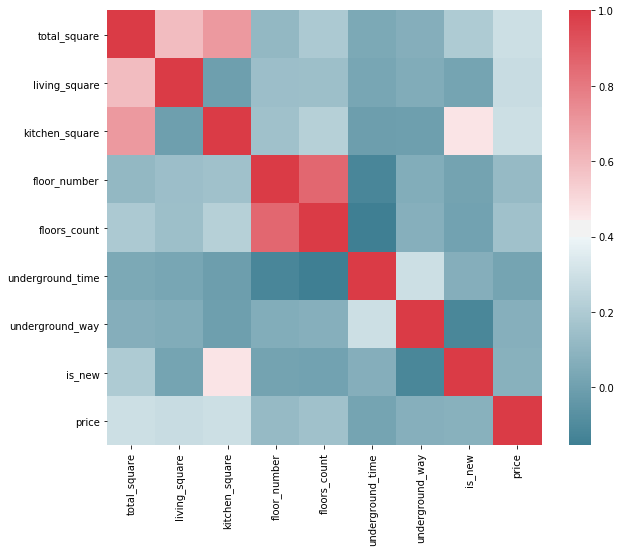

In [98]:
f, ax = plt.subplots(figsize=(10, 8))
corr = flats_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Видим что признаки `living_square` и `kitchen_square` достаточно сильно коррелируют с признаком `total_square`. А также `floor_number` сильно коррелирует с `floors_count`, что на самом деле тоже естественно: "чем меньше этажей в доме, тем на меньшем этаже может располагаться квартира".  
Поэтому давайте также удалим следующие признаки: `living_square`, `kitchen_square` и `floors_count`

In [99]:
flats_df.drop(['living_square', 'kitchen_square', 'floors_count'], axis=1, inplace=True)

Посмотрим на уникальные значения признака `region`

In [100]:
flats_df['region'].value_counts()

ЦАО    1081
Name: region, dtype: int64

К сожалению в нашем наборе имеются только квартиры из одного региона, а признак соответственно принимает только одно значение, 
что тоже очень плохо ("не имеет никакой разделяющей способностью"). Поэтому этот признак тоже придется удалить.

In [101]:
flats_df.drop(['region'], axis=1, inplace=True)

In [102]:
flats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 7 columns):
total_square        1081 non-null float64
floor_number        1081 non-null int64
underground_time    1036 non-null float64
underground_way     1036 non-null float64
is_new              1021 non-null float64
price               1081 non-null float64
link                1081 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 59.2+ KB


У нас остались признаки с пропусками (`underground_time`, `underground_way`, `is_new`), но пропусков не так много. 
Поэтому давайте заменим пропуски на медианные значения в признаке `underground_time`. А в признаках `underground_way`и 
`is_new` на моду (эти признаки бинарные, поэтому мы не можем на медианные значения заменить).

In [105]:
flats_df['underground_time'].fillna(flats_df['underground_time'].median(), inplace=True)

In [112]:
flats_df['is_new'].fillna(flats_df['is_new'].mode()[0], inplace=True)
flats_df['underground_way'].fillna(flats_df['underground_way'].mode()[0], inplace=True)

In [113]:
flats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 7 columns):
total_square        1081 non-null float64
floor_number        1081 non-null int64
underground_time    1081 non-null float64
underground_way     1081 non-null float64
is_new              1081 non-null float64
price               1081 non-null float64
link                1081 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 59.2+ KB


Посмотрим на разброс наших признаков с помощью boxplot-диаграммы

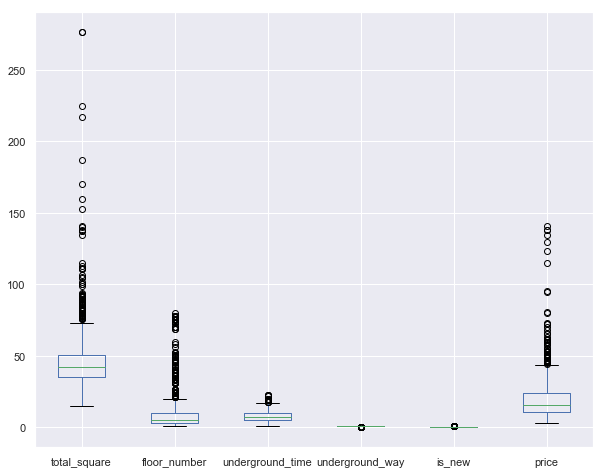

In [149]:
flats_df.boxplot()

Видим что, есть признаки с большим разбросом, например `total_square`. Центрируем и нормируем наши признаки (без признака `link`). 

In [222]:
normalized_df=(flats_df.iloc[:,:-1]-flats_df.iloc[:,:-1].mean())/flats_df.iloc[:,:-1].std() 

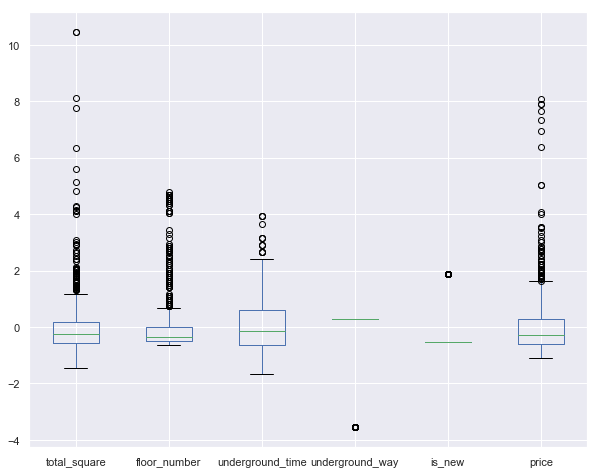

In [223]:
normalized_df.boxplot()

Выделим в отдельные переменные целевой признак `price` и остальные независимые переменные (кроме `link`). Это необходимо для кластеризации и построения регрессионной модели.

In [233]:
X = normalized_df.loc[:,:'is_new'] 
X.head()

,total_square,floor_number,underground_time,underground_way,is_new
0,-0.749857,-0.213392,-1.412881,-3.559749,1.881154
1,0.134065,4.109221,-0.143918,0.280659,-0.531097
2,-0.681512,-0.007553,-0.397710,0.280659,-0.531097
3,0.796095,-0.282005,-0.143918,0.280659,1.881154
4,-0.350725,2.736963,-0.397710,0.280659,1.881154


In [234]:
Y = normalized_df['price'] # целевой признак
Y.head()

0   -0.664064
1    0.248418
2   -0.758972
3    0.546882
4    0.022453
Name: price, dtype: float64

In [230]:
Links = flats_df['link']
Links.head()

0    https://www.cian.ru/sale/flat/222751749/
1    https://www.cian.ru/sale/flat/221828977/
2    https://www.cian.ru/sale/flat/217566898/
3    https://www.cian.ru/sale/flat/217400473/
4    https://www.cian.ru/sale/flat/210037899/
Name: link, dtype: object

# 3. Кластеризация данных
Для кластеризации будем использовать метод K-средних. Оптимальное количество кластеров будем подбирать с помощью Silhouette метода. 

In [235]:
# пробная кластеризация
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM_STATE)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=17, tol=0.0001,
    verbose=0)

Визуализируем полученные нами кластеры. Для этого сначала понизим размерность данных с помощью метода главных компонент (PCA)

In [238]:
# Выполняем снижение размерности
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [239]:
# функция визуализирует результаты кластеризации
def plot_pca_clustering(labels, X_pca):
    colors = {1:'bo',2:'go',3:'ro', 4:'ko', 5:'co'}
    for cluster_label in set(labels):
        plt.plot(X_pca[labels == cluster_label, 0], 
                 X_pca[labels == cluster_label, 1], 
                 colors[cluster_label + 1], 
                 label='Cluster {}'.format(cluster_label + 1))
    plt.legend()
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')

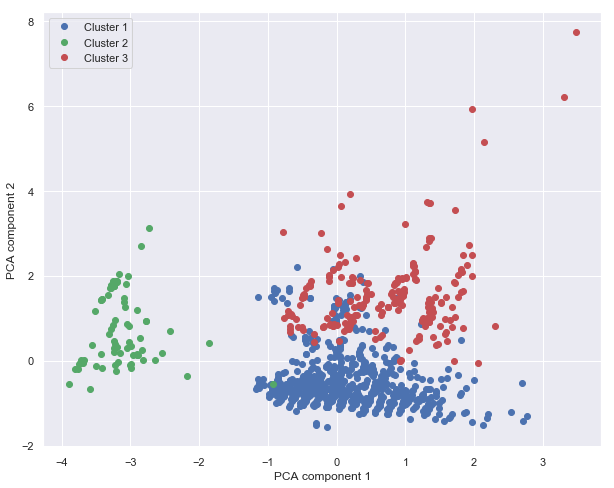

In [240]:
plot_pca_clustering(kmeans.labels_, X_pca)

Из полученных проекций можно увидеть, что можно выделить 2 кластера и можно заметить, что присутствует много выбросов, которые рассеянны.  
Давайте подберем оптимальное количество кластеров и выполним кластеризацию с оптимальным количеством кластеров.

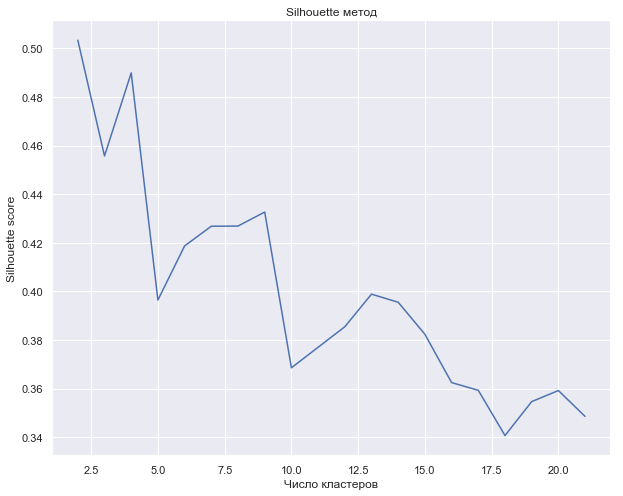

In [243]:
s = []
for i in range(2, 22):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(X)
    s.append(metrics.silhouette_score(X, kmeans.labels_))
plt.plot(range(2, 22), s)
plt.title('Silhouette метод')
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette score')
plt.show()

Оптимальным количеством кластером считается то, при котором Silhouette принимает максимальное значение. 
В нашем случае отчетливо видно что максимальное значение эта метрика принимает при числе кластеров равном 2.

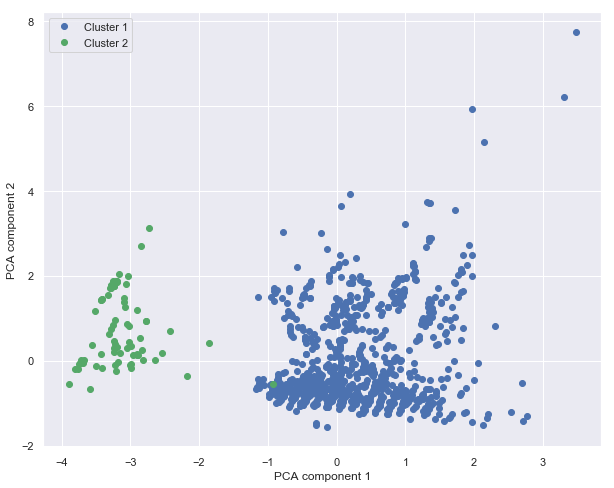

In [244]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM_STATE)
kmeans.fit(X)
plot_pca_clustering(kmeans.labels_, X_pca)

Давайте попробуем итерпретировать полученные кластеры. Мы видим, что по первой главной компоненте просходит четкое разделение данных на два кластера. Давайте посмотрим как связаны каждая из главных компонент с исходными признаками. 

In [251]:
pca.components_ # матрица нагрузок (связи компонент с исходными признаками)
# по строкам - компоненты
# по столбцам - исходные признаки

array([[ 0.26074138, -0.0280067 ,  0.68753694,  0.6732559 ,  0.07244998],
       [ 0.64677643,  0.37381114, -0.12379167, -0.17620049,  0.62894713]])

Заметим, что первая главная компонента наиболее сильно связана с 3-им (**0,68**) `underground_time` и 4-ым признаками (**0,67**) `underground_way`. Поэтому можно предположить, что в одном кластере находятся квартиры наиболее удаленные от метро, а в другом кластере - квартиры наименее удаленные от метро. Давайте также посмотрим на статистики признаков для каждого из кластеров.

In [248]:
flats_df[kmeans.labels_==0].describe() # квартиры, которые были отнесены в первый кластер "синий"

,total_square,floor_number,underground_time,underground_way,is_new,price
count,1002.000000,1002.000000,1002.000000,1002.0,1002.000000,1002.000000
mean,47.487126,10.349301,7.889222,1.0,0.206587,20.228803
std,22.476428,14.985299,3.856401,0.0,0.405059,15.330694
min,15.000000,1.000000,1.000000,1.0,0.000000,3.439999
25%,35.000000,3.000000,5.000000,1.0,0.000000,10.812500
50%,42.000000,5.000000,7.000000,1.0,0.000000,16.000000
75%,51.600000,10.000000,10.000000,1.0,0.000000,24.795250
max,276.300000,80.000000,23.000000,1.0,1.000000,141.050000


In [249]:
flats_df[kmeans.labels_==1].describe() # квартиры, которые были отнесены в первый кластер "зеленый"

,total_square,floor_number,underground_time,underground_way,is_new,price
count,79.000000,79.000000,79.000000,79.0,79.000000,79.000000
mean,41.609494,7.075949,3.481013,0.0,0.392405,14.038475
std,12.408679,7.017875,2.422442,0.0,0.491406,7.662786
min,15.300000,1.000000,1.000000,0.0,0.000000,3.790000
25%,33.150000,3.000000,2.000000,0.0,0.000000,9.650000
50%,43.000000,5.000000,3.000000,0.0,0.000000,12.000000
75%,47.000000,7.000000,4.500000,0.0,1.000000,16.596530
max,89.400000,38.000000,17.000000,0.0,1.000000,53.176000


Сразу заметим, что к первому кластеру относятся те квартиры от которых до метро быстрее и удобнее добираться пешком **`underground_way` = 1**. А ко второму кластеру относятся те квартиры от которых до метро добираться быстрее и удобнее на машине **`underground_way` = 0**.

# 4. Прогнозирование цены на квартиру
Для прогнозирования будем строить регрессионную модель. В качестве модели возьмем решающие деревья (**Decision Trees**) и линейную регрессию (**Linear Regression**). В качестве метрики будем использовать **MAE - Mean Absolute Error**, поскольку она более интерпретируемы чем ,например, **RMSE**. Вначале разделим нашу выборку на обучающую `X_train` и тестовую `X_test`

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

## 4.1 Decision Tree

### Модель без настройки параметров

In [333]:
# обучение модели
reg_tree_simple = DecisionTreeRegressor(random_state=RANDOM_STATE)
reg_tree_simple.fit(X_train, y_train)
reg_tree_simple_pred = reg_tree_simple.predict(X_test)

In [334]:
# качество полученной модели
reg_tree_simple_MAE = metrics.mean_absolute_error(y_test, reg_tree_simple_pred)
print("MAE = {:.3} млн руб".format(reg_tree_simple_MAE))

MAE = 0.309 млн руб


Получается, что наша модель в среднем ошибается на 309 тыс. рублей, что в принципе для начала неплохо, если учесть, что квартиры стоят от 3 до 141 млн. рублей. 

In [335]:
reg_tree_simple.feature_importances_ # важность признаков. Наиболее важным признаком оказалась жилая площадь

array([0.87611458, 0.06832236, 0.03295309, 0.00283395, 0.01977602])

### Модель с настройкой параметров

In [336]:
reg_tree_custom = DecisionTreeRegressor(random_state=RANDOM_STATE)
grid_params = {'max_depth' : list(range(2,10)), # параметры, которые будем подбирать
                'min_samples_split' : list(range(5,100,10))}
reg_tree_grid = GridSearchCV(reg_tree_custom, 
                             grid_params, 
                             cv=5, 
                             n_jobs=-1, 
                             verbose=True, 
                             scoring='mean_absolute_error')
reg_tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=17,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=True)

In [337]:
reg_tree_grid.best_params_ # лучшие параметры

{'max_depth': 8, 'min_samples_split': 15}

Обучим модель решающее дерево, используя оптимальные параметры

In [338]:
reg_tree_custom = DecisionTreeRegressor(max_depth=8, min_samples_split=15, random_state=RANDOM_STATE)
reg_tree_custom.fit(X_train, y_train)
reg_tree_simple_pred = reg_tree_custom.predict(X_test)
reg_tree_custom_MAE = metrics.mean_absolute_error(y_test, reg_tree_simple_pred)
print("MAE = {:.3} млн руб".format(reg_tree_custom_MAE))

MAE = 0.285 млн руб


С оптимальными параметрами решающее дерево немного лучше справляется с прогнозированием

## 4.2 Random Forest


### Модель без настройки параметров

In [326]:
reg_rf = RandomForestRegressor(random_state=RANDOM_STATE)
reg_rf.fit(X_train, y_train)
reg_rf_predicted = reg_rf.predict(X_test)
reg_rf_MAE = metrics.mean_absolute_error(y_test, reg_rf_predicted)
print("MAE = {:.3} млн руб".format(reg_rf_MAE))

MAE = 0.253 млн руб


Видим что случайный лес без настройки параметров справляется с задачей намного лучше обычного решающего дерева.

### Модель с настройкой параметров

In [330]:
reg_rf_custom = RandomForestRegressor(random_state=RANDOM_STATE)
rf_grid_params = {'max_depth' : list(range(2,10)), # параметры, которые будем подбирать
               'n_estimators' : list(range(50,500,20))}
reg_rf_grid = GridSearchCV(reg_rf_custom, 
                             rf_grid_params, 
                             cv=5, 
                             n_jobs=-1, 
                             verbose=True, 
                             scoring='mean_absolute_error')
reg_rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 184 candidates, totalling 920 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 920 out of 920 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=True)

In [331]:
reg_rf_grid.best_params_

{'max_depth': 9, 'n_estimators': 410}

In [332]:
reg_rf_custom = RandomForestRegressor(n_estimators=410, max_depth=9, random_state=RANDOM_STATE)
reg_rf_custom.fit(X_train, y_train)
reg_rf_custom_predicted = reg_rf_custom.predict(X_test)
reg_rf_custom_MAE = metrics.mean_absolute_error(y_test, reg_rf_custom_predicted)
print("MAE = {:.3} млн руб".format(reg_rf_custom_MAE))

MAE = 0.243 млн руб


Ошибку удалось снизить за счет оптимизации параметров

## 4.3 Linear Regression
Сначала обучим обычную линейную регрессию, потом обучим Ridge регрессию - линейная регрессия с L2-регуляризацией.

In [319]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
reg_lin_predicted = reg_lin.predict(X_test)
reg_lin_MAE = metrics.mean_absolute_error(y_test, reg_lin_predicted)
print("MAE = {:.3} млн руб".format(reg_lin_MAE))

MAE = 0.293 млн руб


In [324]:
reg_ridge = Ridge(random_state=RANDOM_STATE, alpha=0.1)
reg_ridge.fit(X_train, y_train)
reg_ridge_predicted = reg_ridge.predict(X_test)
reg_ridge_MAE = metrics.mean_absolute_error(y_test, reg_ridge_predicted)
print("MAE = {:.3} млн руб".format(reg_ridge_MAE))

MAE = 0.293 млн руб


## 4.4 Итог
Подведем итоги применения разных моделей для решения задачи прогнозирования цены квартиры. Были получены следующие результаты

In [341]:
print(" МАЕ Decision Tree (default)               : {:.3} тыс. руб.".format(reg_tree_simple_MAE))
print(" МАЕ Decision Tree (custom)                : {:.3} тыс. руб.".format(reg_tree_custom_MAE))
print(" МАЕ Random Forest (default)               : {:.3} тыс. руб.".format(reg_rf_MAE))
print(" МАЕ Random Forest (custom)                : {:.3} тыс. руб.".format(reg_rf_custom_MAE))
print(" МАЕ Linear Regression                     : {:.3} тыс. руб.".format(reg_lin_MAE))
print(" МАЕ Linear Regression  + L2 Regularization: {:.3} тыс. руб.".format(reg_ridge_MAE))

 МАЕ Decision Tree (default)               : 0.309 тыс. руб.
 МАЕ Decision Tree (custom)                : 0.285 тыс. руб.
 МАЕ Random Forest (default)               : 0.253 тыс. руб.
 МАЕ Random Forest (custom)                : 0.243 тыс. руб.
 МАЕ Linear Regression                     : 0.293 тыс. руб.
 МАЕ Linear Regression  + L2 Regularization: 0.293 тыс. руб.


Как можно заметить, с задачей прогнозирования в данном случае лучше всех справился случайный лес с настройкой параметров.